#WOMANIUM 2024 Project JMM Updates


We use the code from [Jarvis Tools Notebooks](https://github.com/JARVIS-Materials-Design/jarvis-tools-notebooks?tab=readme-ov-file#intro) and this [tutorial](https://forecastegy.com/posts/lightgbm-binary-classification-python/) to train and test our model supervised machine learning model LightGBM and retrieve our dataset. We realized that we were training on too many features so we attempt to reduce them by performing Principal Component Analysis that was inspired by this [hackathon submission](https://github.com/craftingweb/HackPrinceton/blob/main/pca_features.py).

## Preparing the data

In [1]:
!pip install jarvis-tools
!pip install pandas

In [2]:
from jarvis.db.figshare import data #retrieve data of materials
import pandas as pd #for data manipulation and creating dataframes which are like tables
df=pd.DataFrame(data('dft_3d')) #3d dataset includes geometric and visual properties

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


In [3]:
#Based on the Accelerated Discovery of Efficient Solar Cell Materials Using Quantum and Machine Learning Methods,
#we are interested in materials with SLME values > 10%
#remove the data that does not have SLME values
df_slme = df[df['slme'] != 'na'].copy()
#to compare the slme values we need to convert it to a float
df_slme.loc[:,'slme'] = df_slme['slme'].astype(float)
#add a new column slme_10 that has a 1 if slme value >=10.0 otherwise 0
df_slme.loc[:,'slme_10'] = (df_slme['slme'] >= 10.0).astype(int)
df_slme #display the data

,jid,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,atoms,slme,magmom_oszicar,...,poisson,raw_files,nat,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,reference,search,slme_10
20,JVASP-60702,61,Pbca,PdSe8Cl2,-0.15071,OptB88vdW,1.197,"{'lattice_mat': [[9.067075684180468, -0.0, 0.0...",32.6,0.0,...,na,"[DFPT,JVASP-60702.zip,https://ndownloader.figs...",44,na,na,na,na,mp-567437,-Cl-Pd-Se,1
23,JVASP-86436,148,R-3,LiSbF6,-2.61531,OptB88vdW,4.907,"{'lattice_mat': [[4.509029640475962, 0.0564034...",21.81,0.0,...,na,"[OPT-LOPTICS,JVASP-86436.zip,https://ndownload...",8,na,na,na,na,mp-3980,-F-Li-Sb,1
24,JVASP-1372,216,F-43m,AlAs,-0.57639,OptB88vdW,1.681,"{'lattice_mat': [[3.5058938597621094, -3.08124...",17.06,0.0,...,0.25,"[FD-ELAST,JVASP-1372.zip,https://ndownloader.f...",2,68.87,42.58,2.276,na,mp-2172,-Al-As,1
25,JVASP-14873,221,Pm-3m,SrB6,-0.49796,OptB88vdW,0.016,"{'lattice_mat': [[4.191262576674699, 0.0, -0.0...",6.11,0.0,...,0.2,"[FD-ELAST,JVASP-14873.zip,https://ndownloader....",7,150.6,125.7,0.256,na,mp-242,-B-Sr,0
26,JVASP-28397,53,Pmna,SiS,-0.38924,OptB88vdW,0.658,"{'lattice_mat': [[0.0, -3.9587610833154616, 0....",31.59,na,...,0.39,"[FD-ELAST,JVASP-28397.zip,https://ndownloader....",8,6.63,5.44,0.959,na,mp-1023900,-S-Si,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75345,JVASP-152501,88,I4_1/a,Li4HN,-0.56067,OptB88vdW,2.120,"{'lattice_mat': [[-2.4135795217419225, 2.41357...",2.94,0.0,...,na,[],12,na,na,3.183,na,auid-ac967cceb96b5f2b,-H-Li-N,0
75566,JVASP-156465,216,F-43m,PmCdGa,-0.44795,OptB88vdW,0.050,"{'lattice_mat': [[-0.0, 3.3728792894010553, 3....",5.84,0.0,...,na,[],3,na,na,0.113,na,953260,-Cd-Ga-Pm,0
75593,JVASP-156446,216,F-43m,HfInAu,-0.39541,OptB88vdW,0.441,"{'lattice_mat': [[0.0, 3.225842292903002, 3.22...",13.63,0.0,...,na,[],3,na,na,0.469,na,947461,-Au-Hf-In,1
75961,JVASP-156363,216,F-43m,HfPdPb,-0.42246,OptB88vdW,0.310,"{'lattice_mat': [[0.0, 3.218164909882003, 3.21...",5.84,0.0,...,na,[],3,na,na,0.278,na,897636,-Hf-Pb-Pd,0


In [4]:
# Getting shape of the df
shape = df.shape

# Printing Number of columns
print('Number of columns :', shape[1])

Number of columns : 64


In [5]:
#Drop the columns that are not categorical or numerical such as IDs or arrays
df_slme = df_slme.drop(columns=['jid', 'atoms', 'elastic_tensor', 'effective_masses_300K', 'modes', 'icsd','efg', 'xml_data_link', 'raw_files', 'reference', 'search'])

In [6]:
#replace na with NaN
import numpy as np
df_slme.replace('na', np.nan,  inplace=True)


C:\Users\Tanu\AppData\Local\Temp\ipykernel_24652\3771167460.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_slme.replace('na', np.nan,  inplace=True)


# Principal Component Analysis
## What is PCA?
- unsupervised learning algorithm technique to reduce the input features while retaining as much of the original data.
- It uses an [orthogonal transformation that converts a set of correlated variables to a set of *uncorrelated* variables](https://www.geeksforgeeks.org/principal-component-analysis-pca/). This makes it easier to understand what each variable represents for continuous variables.
- [In depth explanation of PCA](https://www.youtube.com/watch?v=_UVHneBUBW0)

## Why do PCA?
- We have too many features which can lead to overfitting and increased computation time. [As the number of dimensions increase, the number of possible combinations of features increases](https://www.geeksforgeeks.org/principal-component-analysis-pca/).

In [7]:
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

### 1. Standardize the features

This means that each variable has a mean of 0 and standard deviation of 1. This is done by subtracting the mean and dividing it by the standard deviation. We are changing the mean and standard deviation to a standard normal distribution.

$$z = (value - mean) / standard deviation$$


Why do we standardize features?

It handles highly varying magnitudes/values/units. It prevents features from dominating other features when we train the model because some features may have larger values than others which will allow it to give more contribution to the distance computation. [For example, we a have 2 dimensional data set with height in meters and weight in pounds, with ranges 1-2 meters and 10 to 200 lbs respectively, then the weight will contribute more just because it has larger values](https://builtin.com/data-science/when-and-why-standardize-your-data)

In [8]:
#save target and original columns remove target label for pca
target_pca = df_slme["slme_10"]
df_pca = df_slme.drop(columns=['slme_10', 'slme'])


In [9]:
#need to remove all non numeric values to use standard scaler
df_pca =  df_pca.select_dtypes(include=['number'])

In [10]:
#save original columns
original_columns = df_pca.columns

In [11]:
print(df_pca.columns)

Index(['formation_energy_peratom', 'optb88vdw_bandgap', 'magmom_oszicar',
       'spillage', 'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut',
       'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy',
       'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
       'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon',
       'exfoliation_energy', 'density', 'poisson', 'nat', 'bulk_modulus_kv',
       'shear_modulus_gv', 'mbj_bandgap', 'hse_gap'],
      dtype='object')


In [12]:
imputer = SimpleImputer(strategy='mean')
df_pca = imputer.fit_transform(df_pca)

In [13]:
#Standardize features
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_pca)

In [14]:
#Select number of components we want - MARIA How do we determine number of principal components
pca = PCA(n_components = 2)
pca.fit(df_pca_scaled)


,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [15]:
#Transform the the scaled dataset
df_pca_transformed = pca.transform(df_pca_scaled)


In [16]:
components_df = pd.DataFrame(
    pca.components_,
    columns = original_columns, #columns of original table of features
    index = [f"PC{i+1}" for i in range(pca.n_components_)] #creates an index for each component
)
#print(components_df)

In [17]:
# Sum the absolute contributions for each feature across all  components
importance = components_df.abs().sum(axis=0)

In [18]:
#sort the features based on their total importance
sorted_importance = importance.sort_values(ascending = False)
print(sorted_importance)

pkappa                                  0.607992
nkappa                                  0.606771
ncond                                   0.605006
pcond                                   0.604511
epsy                                    0.418861
epsx                                    0.418282
epsz                                    0.408765
mepsy                                   0.361488
mepsx                                   0.360778
mepsz                                   0.352197
optb88vdw_bandgap                       0.344008
mbj_bandgap                             0.329122
kpoint_length_unit                      0.249794
p-Seebeck                               0.246776
formation_energy_peratom                0.240663
encut                                   0.199444
avg_hole_mass                           0.198389
maxdiff_bz                              0.174566
optb88vdw_total_energy                  0.166654
nat                                     0.162747
n-Seebeck           

In [19]:
print(pca.explained_variance_ratio_)

[0.16563438 0.08698575]


In [20]:
#table of principal components
df_pca1 = pd.DataFrame(
    df_pca_transformed,
    columns=['PC{}'.format(i+1)
              for i in range(pca.n_components_)]
)
print(df_pca1)

           PC1       PC2
0    -1.284272 -0.139510
1    -1.354150  0.545418
2     0.989838 -0.442970
3     1.768802 -0.055950
4    -0.155959 -0.192884
...        ...       ...
9765 -0.404281  0.005585
9766  8.767292 -2.778176
9767  3.308699 -1.140276
9768  3.405258 -1.150997
9769  1.793194 -0.545783

[9770 rows x 2 columns]


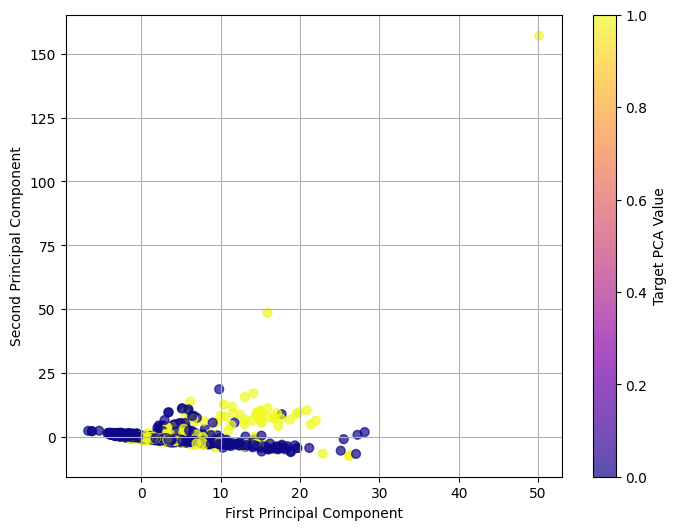

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Create the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_pca_transformed[:, 0],
    df_pca_transformed[:, 1],
    c=target_pca,
    cmap='plasma',
    alpha=0.7,  # Adjust transparency to visualize overlap
    s=40        # Size of points
)

# Label x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Add a colorbar directly linked to the scatter plot
cbar = plt.colorbar(scatter)  # Pass the scatter plot object
cbar.set_label('Target PCA Value')  # Label for the colorbar

plt.grid(True)
plt.show()


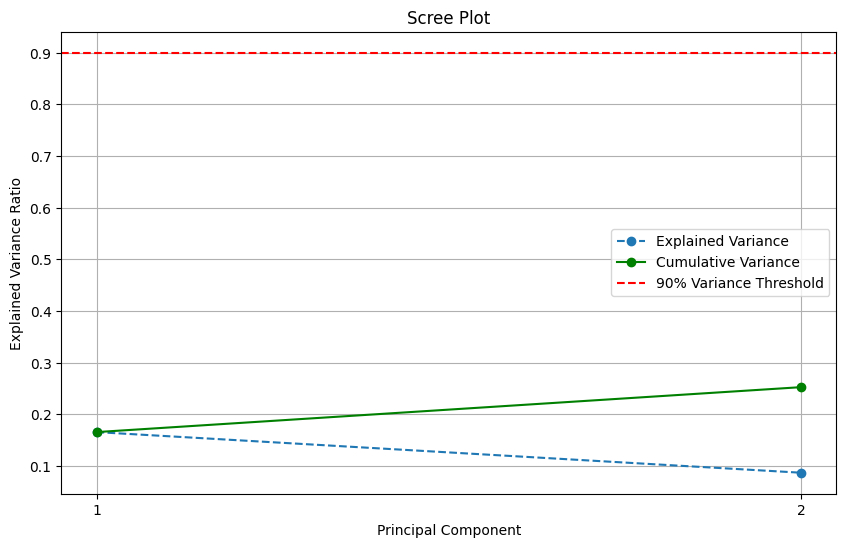

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assume `pca` is the trained PCA object
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(explained_variance_ratio) + 1),  # X-axis is component index
    explained_variance_ratio,
    marker='o', linestyle='--', label='Explained Variance'
)

# Cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o', linestyle='-', color='green', label='Cumulative Variance'
)

# Add labels, title, and legend
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))  # Add all component numbers as ticks
plt.axhline(y=0.9, color='red', linestyle='--', label='90% Variance Threshold')  # Optional threshold
plt.legend()
plt.grid(True)
plt.show()

# Principal Component Analysis with 3 (TO DO)



#LightGBM Supervised Machine Learning Model

 This model is a binary classifier that will help us decide whether a material is potentially suitable or not for Photovoltaic cells. The criteria for creating the dataset was based on the paper on [Accelerated Discovery of Efficient Solar Cell Materials Using Quantum and Machine-Learning Methods](https://pubs.acs.org/doi/full/10.1021/acs.chemmater.9b02166)

In [23]:
#convert columns as int/float/boolean as appropriate. This is important for when we train our model

col_convert_float = [ 'magmom_oszicar', 'spillage', 'maxdiff_mesh', 'maxdiff_bz', 'epsx', 'epsy', 'epsz',
    'mepsx', 'mepsy', 'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
    'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
    'dfpt_piezo_max_dielectric_electronic', 'dfpt_piezo_max_dielectric_ionic',
    'max_ir_mode', 'min_ir_mode', 'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact',
    'ncond', 'pcond', 'nkappa', 'pkappa', 'Tc_supercon', 'exfoliation_energy', 'poisson',
    'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap']

for col_name in col_convert_float:
    df_slme.loc[:,col_name] = df_slme[col_name].astype(float)


df_slme.loc[:,'encut'] = df_slme['encut'].fillna(0).astype(int)
df_slme.loc[:,'kpoint_length_unit'] = df_slme['kpoint_length_unit'].fillna(0).astype(int)

In [24]:
#display table to see table with cleaned values
df_slme

,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,slme,magmom_oszicar,spillage,kpoint_length_unit,...,spg,crys,density,poisson,nat,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,slme_10
20,61,Pbca,PdSe8Cl2,-0.15071,OptB88vdW,1.197,32.60,0.0,NaN,35.0,...,61,orthorhombic,4.471,NaN,44,NaN,NaN,NaN,NaN,1
23,148,R-3,LiSbF6,-2.61531,OptB88vdW,4.907,21.81,0.0,NaN,20.0,...,148,trigonal,3.997,NaN,8,NaN,NaN,NaN,NaN,1
24,216,F-43m,AlAs,-0.57639,OptB88vdW,1.681,17.06,0.0,NaN,30.0,...,216,cubic,3.607,0.25,2,68.87,42.58,2.276,NaN,1
25,221,Pm-3m,SrB6,-0.49796,OptB88vdW,0.016,6.11,0.0,NaN,30.0,...,221,cubic,3.439,0.20,7,150.60,125.70,0.256,NaN,0
26,53,Pmna,SiS,-0.38924,OptB88vdW,0.658,31.59,NaN,NaN,40.0,...,53,orthorhombic,0.633,0.39,8,6.63,5.44,0.959,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75345,88,I4_1/a,Li4HN,-0.56067,OptB88vdW,2.120,2.94,0.0,NaN,20.0,...,88,tetragonal,1.237,NaN,12,NaN,NaN,3.183,NaN,0
75566,216,F-43m,PmCdGa,-0.44795,OptB88vdW,0.050,5.84,0.0,NaN,40.0,...,216,cubic,7.079,NaN,3,NaN,NaN,0.113,NaN,0
75593,216,F-43m,HfInAu,-0.39541,OptB88vdW,0.441,13.63,0.0,NaN,35.0,...,216,cubic,12.126,NaN,3,NaN,NaN,0.469,NaN,1
75961,216,F-43m,HfPdPb,-0.42246,OptB88vdW,0.310,5.84,0.0,NaN,35.0,...,216,cubic,12.259,NaN,3,NaN,NaN,0.278,NaN,0


In [25]:
#this code was used to investigate the values in each column
#pd.set_option('display.max_rows',None)
#print(df_slme['search'])

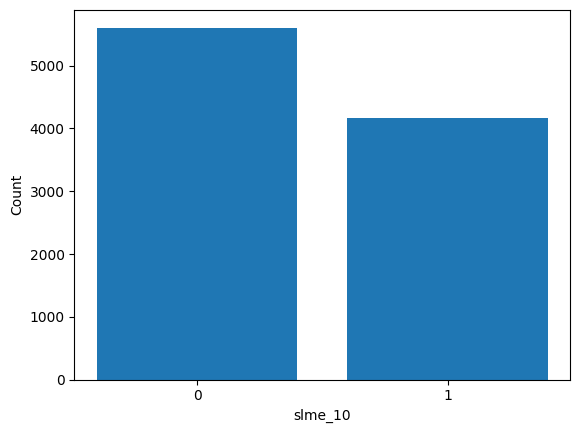

In [26]:
#check if the data is imbalanced this means if there are more 1s and 0s or vice versa
import matplotlib.pyplot as plt
%matplotlib inline
check_imbalance = df_slme['slme_10'].value_counts().reset_index()
check_imbalance.columns = ['slme_10', 'count']

# Create the bar plot using matplotlib
plt.bar(check_imbalance['slme_10'], check_imbalance['count'])
plt.xlabel('slme_10')
plt.ylabel('Count')
plt.xticks(check_imbalance['slme_10'])
plt.show()

# Split the data into training and test

In [27]:
df_slme.columns

Index(['spg_number', 'spg_symbol', 'formula', 'formation_energy_peratom',
       'func', 'optb88vdw_bandgap', 'slme', 'magmom_oszicar', 'spillage',
       'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut',
       'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy',
       'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
       'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality',
       'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'nat',
       'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap',
       'slme_10'],
      dtype='object')

In [28]:
#select only 3 features for continuous variables.
#Keeping all categorical values
#selecting slme_10, slme, and formula columns because it is handled in th efollowing code
df_slme_pca3 = df_slme.loc[:, ['nkappa', 'pkappa', 'ncond', 'slme_10','slme', 'formula','spg_number', 'spg_symbol', 'func', 'dimensionality', 'spg', 'crys', 'typ' ]]

In [29]:
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
#features is what the model will use to predict the target variable, slme_10
features = df_slme_pca3.drop(columns=['slme_10','slme', 'formula'])
target = df_slme_pca3['slme_10']

#test dataset size is 20% and traing dataset is 80% (random_state is the seed so that it chooses random materials to put in training nad testing data set)
random.seed(datetime.now().timestamp())
random_num = random.randint(1,100)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=random_num)

#get the indices of the test values so we can retrieve the material's formula later
test_indices = features_test.index


In [30]:
#make sure that we don't train with slme_10 and slme bychecking the columns
features.columns

Index(['nkappa', 'pkappa', 'ncond', 'spg_number', 'spg_symbol', 'func',
       'dimensionality', 'spg', 'crys', 'typ'],
      dtype='object')

## Prepocess categorical data and cut down using MCA

[MCA is PCA but for categorical values](https://www.geeksforgeeks.org/what-is-correspondence-analysis/)

In [31]:
!pip install category_encoders

In [32]:
#convert categorical data into integers
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['spg_number', 'spg_symbol', 'func', 'dimensionality', 'spg', 'crys', 'typ'])
features_train = encoder.fit_transform(features_train)
features_test = encoder.fit_transform(features_test)

In [33]:
#make sure that there we raplace missing values with NaNs
features_train = features_train.replace('?', np.nan)
features_test = features_test.replace('?', np.nan)

## Setting the classfier model hyperparameters and training

In [34]:
!pip install lightgbm
from lightgbm import LGBMClassifier
# learning rate = how much each tree contributes to the overall predicition. The lower learning rate is better but takes longer training time
#n_estimators = number of trees to build. Higher value means longer training time
#num_leaves= number of leaves in each tree. Higher value means a less regularized model which can lead to overfitting

#hyperparameters from the paper mentioned above
model = LGBMClassifier(learning_rate=0.01, n_estimators=5000, num_leaves=100, max_depth=50, boosting_type='gbdt', min_child_samples = 20, min_child_weight = 0.001, min_split_gain=0.0, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0, subsample_for_bin=200000,subsample_freq=1)

In [35]:
model.fit(features_train, target_train)

[LightGBM] [Info] Number of positive: 3335, number of negative: 4481
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 7816, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426689 -> initscore=-0.295374
[LightGBM] [Info] Start training from score -0.295374


,boosting_type,'gbdt'
,num_leaves,100
,max_depth,50
,learning_rate,0.01
,n_estimators,5000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Make predictions

In [36]:
#this directly predicts the class for each instance in the test set. the threshold of 0.5 fpr predicted probabilities
pred = model.predict(features_test)

In [37]:
#these are predicted probabilities rather than class predictions
pred_probabilities = model.predict_proba(features_test)[:,1]

In [38]:
#create dataframe to show which materials are suitable or not. This is mapping formulas back to the indices we save earlier

predictions_df = pd.DataFrame({ 'formula' : df_slme.loc[test_indices, 'formula'],
                               'predictions': pred })
print(predictions_df)
print("number of test values predicted: ", len(predictions_df))
print("number of potential materials: ", predictions_df['predictions'].sum())


        formula  predictions
17423    K3BiI6            1
21450  MgH2C3O4            1
8783     BaSrO2            0
27874    AlGaO3            0
23623     Nb2O5            1
...         ...          ...
47613     YB3O6            0
26055   SrCa2I6            1
71930    Rb4CO4            0
17796  Bi2TeSe2            1
43446    LiVBO4            1

[1954 rows x 2 columns]
number of test values predicted:  1954
number of potential materials:  766


# Evaluate the model

Note that the following values used to evaluate the model will vary every time we run all of the cells above because we choose random values for what is included in our testing and training dataset. However, the values should be similar.

In [39]:
#accuracy is one metric. It is the proportion of predictions that the mode got right. Number closer to 1 is good
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(target_test, pred)
print("Accuracy", accuracy )

Accuracy 0.5808597748208802


In [40]:
#log loss is another metric that evaluates the predicted probabilities of membership to a given class. Number closer to 0 is good
from sklearn.metrics import log_loss
loss = log_loss(target_test, pred_probabilities)
print("Log Loss", loss)


Log Loss 0.9370095800431065


In [41]:
#ROC AUC (Area under the ROC curve- Receiver operating characteristic curve: this curve plots the possible true positive rates agains false positive rates) score
#it is an aggregate measure of performance across all possible classification thresholds. Number closer to 1 is good
from sklearn.metrics import roc_auc_score
roc = roc_auc_score(target_test, pred)
print("ROC AUC ", roc)

ROC AUC  0.5660168878166465


In [42]:
#general classification report
from sklearn.metrics import classification_report
report = classification_report(target_test, pred)
print("Classification Report")
print(report)

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.66      0.65      1125
           1       0.51      0.47      0.49       829

    accuracy                           0.58      1954
   macro avg       0.57      0.57      0.57      1954
weighted avg       0.58      0.58      0.58      1954



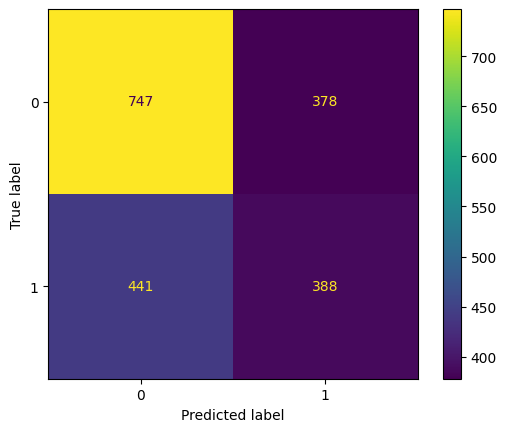

In [43]:
#confusion matrix to summarize performance of a classification model on a set of data where true values are known
from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay.from_predictions(target_test,pred)
plt.show()

# Filter Predicted Materials

We filter the dataset to include only materials predicted as suitable (`predictions = 1`).
This allows us to focus on the most relevant materials for SR-NIEL calculations.


In [44]:
# Required libraries for preparing data for the NIEL calculator
!pip install pymatgen pandas

import pandas as pd
from pymatgen.core import Composition, Element


In [45]:
# Function to extract number of elements, Z values, element names, and threshold energies

# !!!! DEFAULT DISPLACEMENT THRESHOLD ENERGY (Th) IS SET TO 21 eV. This can be changed as needed. !!!!

def get_srniel_summary(formula, default_Th=21):
    """
    Returns a summary for SR-NIEL input:
      - num_elements: number of unique elements
      - Z_list: list of atomic numbers
      - Elements: corresponding element symbols (kept in original formula order)
      - Th_list: displacement threshold energy (same default for all)
    """
    comp = Composition(formula)

    # Get elements in the order they appear in the formula
    elements = list(comp.get_el_amt_dict().keys())

    # Get atomic numbers (Z values) for each element
    Z_list = [Element(e).Z for e in elements]

    # Assign default displacement threshold energy for all elements
    Th_list = [default_Th] * len(elements)

    # Return SR-NIEL-ready information as a dictionary
    return {
        "formula": formula,
        "num_elements": len(elements),
        "Elements": ", ".join(elements),
        "Z_list": ", ".join(map(str, Z_list)),
        "Th_list": ", ".join(map(str, Th_list))
    }

In [46]:
# Filter materials predicted as suitable (kept as a DataFrame)
suitable_df = predictions_df[predictions_df["predictions"] == 1].reset_index(drop=True)

# Generate SR-NIEL summary for these materials
srniel_df = suitable_df["formula"].apply(get_srniel_summary).apply(pd.Series)

# Display results
print("SR-NIEL Summary (predictions = 1 only)\n")
print(srniel_df)

SR-NIEL Summary (predictions = 1 only)

      formula  num_elements     Elements       Z_list         Th_list
0      K3BiI6             3     K, Bi, I   19, 83, 53      21, 21, 21
1    MgH2C3O4             4  Mg, H, C, O  12, 1, 6, 8  21, 21, 21, 21
2       Nb2O5             2        Nb, O        41, 8          21, 21
3       TiOF2             3     Ti, O, F     22, 8, 9      21, 21, 21
4     TiBe2Pt             3   Ti, Be, Pt    22, 4, 78      21, 21, 21
..        ...           ...          ...          ...             ...
761     HoBr3             2       Ho, Br       67, 35          21, 21
762       BiI             2        Bi, I       83, 53          21, 21
763   SrCa2I6             3    Sr, Ca, I   38, 20, 53      21, 21, 21
764  Bi2TeSe2             3   Bi, Te, Se   83, 52, 34      21, 21, 21
765    LiVBO4             4  Li, V, B, O  3, 23, 5, 8  21, 21, 21, 21

[766 rows x 5 columns]


In [47]:
# Dependencies to send data to the SR-NIEL calculator

!pip install requests beautifulsoup4 pandas lxml pymatgen

import requests
import pandas as pd
from bs4 import BeautifulSoup
from pymatgen.core import Composition, Element
import io
import os

# Generate SR-NIEL Summary and get result URLs

For each material, generate a summary including:

- Chemical formula
- Number of elements
- Element symbols
- Atomic numbers
- Threshold energies

Then, we send a request to the SR-NIEL **ELECTRON** calculator for each material to get the result URL. Results are stored in a DataFrame and saved as CSV.

In [48]:
# SR-NIEL electron calculator URL
url = "https://www.sr-niel.org/index.php/sr-niel-web-calculators/niel-calculator-for-electrons-protons-and-ions/electrons-niel-calculator"

def get_niel_data(formula, default_Th=21, Emin=10, Emax=100, fluence=1):
    comp = Composition(formula)
    elements_dict = comp.get_el_amt_dict()

    # Prepare payload
    payload = {
        "FF": "0",
        "TARGET": "0",
        "NELEM": str(len(elements_dict)),
        "Emin": str(Emin),
        "Emax": str(Emax),
        "AddEnergy": "",
        "Fluence": str(fluence),
        "formSubmit": "CALCULATE"
    }

    # Add element-specific data
    for i, (el, amt) in enumerate(elements_dict.items(), start=1):
        payload[f"Z{i}"] = str(Element(el).Z)
        payload[f"Stoich{i}"] = str(amt)
        payload[f"Th{i}"] = str(default_Th)

    # Send request and parse result
    with requests.Session() as session:
        response = session.post(url, data=payload)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        link_tag = soup.find("a", href=True, string=lambda t: t and "RESULT" in t)

        if not link_tag:
            return None, "⚠️ No result link found"

        result_url = link_tag["href"]
        if not result_url.startswith("http"):
            result_url = f"http://www.sr-niel.org/{result_url.lstrip('/')}"

        # Check URL reachability
        status_msg = "✅ Found and validated" if session.get(result_url).status_code == 200 else "⚠️ Link not reachable"
        return result_url, status_msg

In [49]:
# Loop through materials and get real SR-NIEL links
results = []

# TEMPORARY suitable_df
# !!!! COMMENT THIS DATA STRUCTURE IF IT IS NOT USED FOR TESTING !!!!
suitable_df = pd.DataFrame([
    {"formula": "Si", "Th": 21},
    {"formula": "GaAs", "Th": 25},
    {"formula": "Al2O3", "Th": 28},
])

# REMOVE UNTIL HERE


for _, row in suitable_df.iterrows():
    Th_value = 21  # default threshold displacement energy (eV)
    print(f"🔹 Processing {row['formula']} (Th = {Th_value} eV) ...")

    result_url, status = get_niel_data(row["formula"], default_Th=Th_value)
    results.append({
        "Material": row["formula"],
        "Th (eV)": Th_value,
        "Result_URL": result_url,
        "Status": status
    })

    print(status)

# Combine results into DataFrame and save
results_df = pd.DataFrame(results)
print("\n--- SR-NIEL Simulation Result Links ---")
print(results_df)

results_df.to_csv("srniel_result_links.csv", index=False)
print("\n💾 Saved as srniel_result_links.csv")

🔹 Processing Si (Th = 21 eV) ...


✅ Found and validated
🔹 Processing GaAs (Th = 21 eV) ...
✅ Found and validated
🔹 Processing Al2O3 (Th = 21 eV) ...
✅ Found and validated

--- SR-NIEL Simulation Result Links ---
  Material  Th (eV)                                         Result_URL  \
0       Si       21  http://www.sr-niel.org/Simulation/169059niel_e...   
1     GaAs       21  http://www.sr-niel.org/Simulation/160297niel_e...   
2    Al2O3       21  http://www.sr-niel.org/Simulation/799777niel_e...   

                  Status  
0  ✅ Found and validated  
1  ✅ Found and validated  
2  ✅ Found and validated  

💾 Saved as srniel_result_links.csv


Now, we send a request to the SR-NIEL **PROTON** calculator for each material to get the result URL. Results are stored in a DataFrame and saved as CSV.

In [55]:
# SR-NIEL proton calculator URL
PROTON_URL = "https://www.sr-niel.org/index.php/sr-niel-web-calculators/niel-calculator-for-electrons-protons-and-ions/protons-ions-niel-calculator"

def get_niel_data_protons(formula, default_Th=21, Emin=0.0001, Emax=10000, fluence=1, Zi=1, Ionmodel=1, Scale=0):
    """
    Retrieve SR-NIEL result link for proton (Zi=1) or other ion calculations.

    Parameters:
        formula (str): Target material chemical formula (e.g., "Si", "GaAs")
        default_Th (float): Displacement threshold energy (eV)
        Emin, Emax (float): Energy range in MeV
        fluence (float): Particle fluence [cm^-2]
        Zi (int): Incident particle atomic number (1=H, 2=He, etc.)
        Ionmodel (int): 1=Hadron+Coulomb, 2=Only Hadron, 0=Only Coulomb
        Scale (int): 0=No scaling, 1=Linear scaling
    """

    comp = Composition(formula)
    elements_dict = comp.get_el_amt_dict()

    # Prepare payload based on form fields
    payload = {
        "Zi": str(Zi),                # Incident particle (proton = 1)
        "Ionmodel": str(Ionmodel),    # Model selection
        "Scale": str(Scale),          # Hadronic scaling
        "TARGET": "0",                # User defined target
        "NELEM": str(len(elements_dict)),
        "Emin": str(Emin),
        "Emax": str(Emax),
        "AddEnergy": "",
        "Fluence": str(fluence),
        "formSubmit": "CALCULATE"
    }

    # Add element-specific fields
    for i, (el, amt) in enumerate(elements_dict.items(), start=1):
        payload[f"Z{i}"] = str(Element(el).Z)
        payload[f"Stoich{i}"] = str(amt)
        payload[f"Th{i}"] = str(default_Th)

    # Send POST request
    with requests.Session() as session:
        response = session.post(PROTON_URL, data=payload)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")

        # Find the result link (contains "RESULT" in text)
        link_tag = soup.find("a", href=True, string=lambda t: t and "RESULT" in t)

        if not link_tag:
            return None, "⚠️ No result link found"

        result_url = link_tag["href"]
        if not result_url.startswith("http"):
            result_url = f"http://www.sr-niel.org/{result_url.lstrip('/')}"

        # Verify if result URL works
        status_msg = "✅ Found and validated" if session.get(result_url).status_code == 200 else "⚠️ Link not reachable"

        return result_url, status_msg


In [56]:
# Loop through materials and get real SR-NIEL links (for protons)
results = []

# TEMPORARY suitable_df
# !!!! COMMENT THIS DATA STRUCTURE IF IT IS NOT USED FOR TESTING !!!!
suitable_df = pd.DataFrame([
    {"formula": "Si", "Th": 21},
    {"formula": "GaAs", "Th": 25},
    {"formula": "Al2O3", "Th": 28},
])

# Loop through materials
for _, row in suitable_df.iterrows():
    Th_value = row["Th"]
    print(f"🔹 Processing {row['formula']} (Th = {Th_value} eV) ...")

    # Call proton NIEL data fetcher
    result_url, status = get_niel_data_protons(row["formula"], default_Th=Th_value)

    # Store result
    results.append({
        "Material": row["formula"],
        "Th (eV)": Th_value,
        "Result_URL": result_url,
        "Status": status
    })

    print(status)

# Combine results into DataFrame
results_df = pd.DataFrame(results)

print("\n--- SR-NIEL Simulation Result Links (Protons) ---")
print(results_df)

# Save as CSV
results_df.to_csv("srniel_result_links_protons.csv", index=False)
print("\n💾 Saved as srniel_result_links_protons.csv")


🔹 Processing Si (Th = 21 eV) ...
✅ Found and validated
🔹 Processing GaAs (Th = 25 eV) ...
✅ Found and validated
🔹 Processing Al2O3 (Th = 28 eV) ...
✅ Found and validated

--- SR-NIEL Simulation Result Links (Protons) ---
  Material  Th (eV)                                         Result_URL  \
0       Si       21  http://www.sr-niel.org/Simulation/670343niel_p...   
1     GaAs       25  http://www.sr-niel.org/Simulation/359712niel_p...   
2    Al2O3       28  http://www.sr-niel.org/Simulation/515350niel_p...   

                  Status  
0  ✅ Found and validated  
1  ✅ Found and validated  
2  ✅ Found and validated  

💾 Saved as srniel_result_links_protons.csv


# Scrape NIEL Tables and Generate OMERE Input Files

Scrape the SR-NIEL page to extract the NIEL table. Only numeric rows are kept and column names are standardized.

Then, for each material, we save as tab-separated `.txt` files in `omere_inputs` folder

In [ ]:
# Function to get the NIEL table from a given SR-NIEL URL
def scrape_niel_table(url):
    if pd.isna(url):
        return None

    # Fetch page and parse tables
    html = requests.get(url).text
    tables = pd.read_html(io.StringIO(html))

    # Extract first table
    niel_df = tables[0]

    # Keep only rows where the first column is numeric
    niel_df = niel_df[pd.to_numeric(niel_df.iloc[:, 0], errors='coerce').notna()]

    # Keep only the first two columns (Energy and NIEL)
    niel_df = niel_df.iloc[:, :2]

    # Rename columns to match OMERE format
    niel_df.columns = ['Energy_MeV', 'NIEL_MeV_cm2_g']

    return niel_df

ELECTRONS

In [66]:
### FOR ELECTRONS

# Folder to save OMERE input files
omere_dir = "omere_inputs"
os.makedirs(omere_dir, exist_ok=True)

# Create OMERE files for each material
for _, row in results_df.iterrows():
    material, url = row['Material'], row['Result_URL']
    niel_table = scrape_niel_table(url)

    if niel_table is not None:
        # Keep only the two required columns
        omere_file = niel_table[['Energy_MeV', 'NIEL_MeV_cm2_g']]
        filename = os.path.join(omere_dir, f"{material}_e_NIEL.dat")  # Save as .dat file in omere_inputs folder

        # Write file with header starting with "#"
        with open(filename, "w", newline='') as f:
            f.write("# Energy_MeV\tNIEL_MeV_cm2_g\n")
            omere_file.to_csv(f, sep='\t', index=False, header=False, float_format="%.2E")

        print(f"✅ Saved electrons input for {material} as {filename}")
    else:
        print(f"ERROR: No NIEL data found for {material}")


✅ Saved electrons input for Si as omere_inputs\Si_e_NIEL.dat
✅ Saved electrons input for GaAs as omere_inputs\GaAs_e_NIEL.dat
✅ Saved electrons input for Al2O3 as omere_inputs\Al2O3_e_NIEL.dat


In [59]:
input_folder = "omere_inputs"
output_txt = "electron_input_files.txt"

with open(output_txt, "w") as f:
    for filename in os.listdir(input_folder):
        if filename.endswith(".dat"):
            f.write(os.path.join(input_folder, filename) + "\n")

print("electron_input_files.txt updated!")


electron_input_files.txt updated!


PROTONS

In [ ]:
# Folder to save OMERE input files
omere_dir = "omere_inputs"
os.makedirs(omere_dir, exist_ok=True)


for _, row in results_df.iterrows():
    material, url = row['Material'], row['Result_URL']
    niel_table = scrape_niel_table(url)

    if niel_table is not None:
        # Keep only the two required columns
        omere_file = niel_table[['Energy_MeV', 'NIEL_MeV_cm2_g']]
        filename = os.path.join(omere_dir, f"{material}_p_NIEL.dat")

        # Write file with header starting with "#"
        with open(filename, "w", newline='') as f:
            f.write("# Energy_MeV\tNIEL_MeV_cm2_g\n")
            omere_file.to_csv(f, sep='\t', index=False, header=False, float_format="%.2E")

        print(f"✅ Saved protons input for {material} as {filename}")
    else:
        print(f"ERROR: No NIEL data found for {material}")


✅ Saved protons input for Si as omere_inputs\Si_p_NIEL.dat
✅ Saved protons input for GaAs as omere_inputs\GaAs_p_NIEL.dat
✅ Saved protons input for Al2O3 as omere_inputs\Al2O3_p_NIEL.dat


In [63]:
input_folder = "omere_inputs"
output_txt = "proton_input_files.txt"

with open(output_txt, "w") as f:
    for filename in os.listdir(input_folder):
        # Only include proton .dat files
        if filename.endswith("_p_NIEL.dat"):
            f.write(os.path.join(input_folder, filename) + "\n")

print("proton_input_files.txt updated!")


proton_input_files.txt updated!
